In [9]:
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x / 1000))


wandb.login()
api = wandb.Api()

In [2]:
tiny_lora_weights = api.run("pico-lm/pico-relora/ixdq4sof")
small_lora_weights = api.run("pico-lm/pico-relora/a8nvp3mi")
baseline_tiny_swiglu_weights = api.run("pico-lm/pico-relora/fd3vhkzw")
baseline_small_swiglu_weights = api.run("pico-lm/pico-relora/l5f8bcnx")

In [3]:
tlw = pd.DataFrame(tiny_lora_weights.scan_history())
btsw = pd.DataFrame(baseline_tiny_swiglu_weights.scan_history())

In [4]:
slw = pd.DataFrame(small_lora_weights.scan_history())
bssw = pd.DataFrame(baseline_small_swiglu_weights.scan_history())

In [5]:
def get_across_ranges(df: pd.DataFrame, metric_name: str, *ranges):
    if not ranges:
        ranges = (range(12),)
    combos = product(*ranges)
    x = [df[metric_name.format(*combo)].to_numpy() for combo in combos]
    return np.column_stack(x)

In [6]:
TICK_LABEL_SIZE = 14
AXIS_LABEL_SIZE = 16

In [57]:
def plot_ld_metric(
    dfs: list[pd.DataFrame],
    metric_strs: list[str],
    x_title: str,
    y_title: str,
    file_name: str,
    *,
    yerr: bool = False,
    scatter: bool = True,
    every: list[int] = (1, 2, 1, 2),
):
    fig, ax = plt.subplots()

    colours = ["#1E88E5", "#FF992F", "#E81673", "#7A23DD"]
    err_colours = ["#6EADE5", "#FFBA73", "#E87BAB", "#B38DDD"]
    shapes = ["s", "o", "s", "o"]

    legend_elements = []

    for idx, df in enumerate(dfs):
        metricstr = metric_strs[idx]
        vs = get_across_ranges(df, metricstr)
        mu = np.mean(vs, axis=1, keepdims=True)
        sig = np.std(vs, axis=1, mean=mu, ddof=1)
        sem = sig / np.sqrt(vs.shape[1])
        ev = every[idx]
        xs = df["_step"].to_numpy()
        ax.errorbar(
            xs[::ev],
            np.squeeze(mu)[::ev],
            yerr=sem[::ev] if yerr else None,
            color=colours[idx],
            ecolor=err_colours[idx],
            capsize=1,
            elinewidth=1,
            # fmt=,
            markersize=3,
            zorder=3,
        )

        if scatter:
            ax.scatter(
                xs[::ev],
                np.squeeze(mu)[::ev],
                color=colours[idx],
                s=10,
                marker=shapes[idx],
                zorder=5,
            )

        legend_elements.append(
            Line2D(
                [0],
                [0],
                color=colours[idx],
                marker=shapes[idx] if scatter else None,
                linestyle="-",
                label=r"\texttt{"
                f"pico-{'decoder' if idx % 2 == 0 else 'relora'}-"
                f"{'tiny' if idx < 2 else 'small'}}}",
                markersize=5,
            )
        )

    ax.set_xticks(np.arange(0, 20_001, 1_000), labels=[str(i) for i in range(21)])
    ax.set_xlim(-300, 20_300)
    ax.set_axisbelow(True)
    ax.grid(which="major", axis="both", color="#E5E5E5")

    ax.tick_params("both", labelsize=TICK_LABEL_SIZE)

    ax.legend(handles=legend_elements, fontsize=TICK_LABEL_SIZE)

    ax.set_xlabel(x_title, fontdict={"size": AXIS_LABEL_SIZE})
    ax.set_ylabel(y_title, fontdict={"size": AXIS_LABEL_SIZE})

    fig.tight_layout()
    fig.show()
    fig.savefig(f"../graphs/{file_name}.pdf")

# Swiglu PER

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_33785/3048193440.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


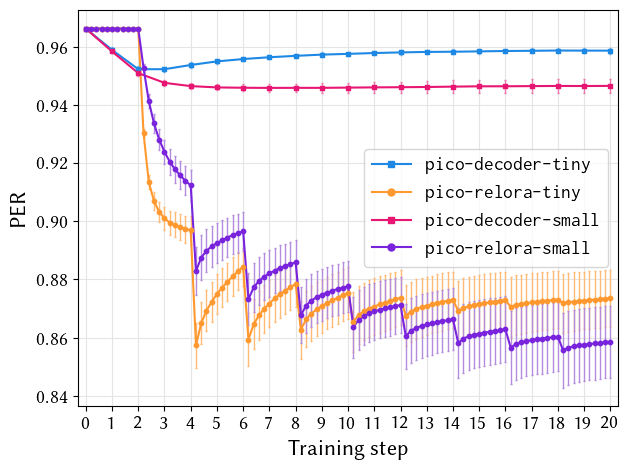

In [ ]:
plot_ld_metric(
    (btsw, tlw, bssw, slw),
    [
        f"per_val/_forward_module.module.layers.{{}}.swiglu.w_2.{'full.' if idx % 2 == 1 else ''}weights"
        for idx in range(4)
    ],
    "Training step",
    "PER",
    "swiglu_per",
    yerr=True,
)

# OV circuit PER

In [30]:
tiny_ov_base = api.run("pico-lm/pico-relora/ep4hgu2s")
small_ov_base = api.run("pico-lm/pico-relora/1p445avk")

In [31]:
tob = pd.DataFrame(tiny_ov_base.scan_history())
sob = pd.DataFrame(small_ov_base.scan_history())

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_33785/612548298.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


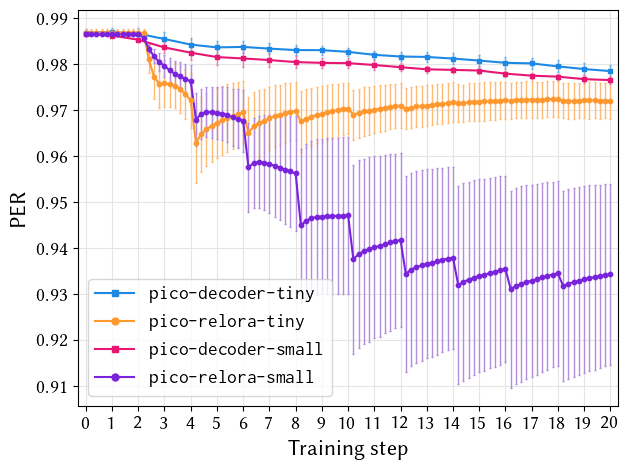

In [58]:
plot_ld_metric(
    (tob, tlw, sob, slw),
    [
        f"per_val/_forward_module.module.layers.{{}}.ov_circuit.{'full.' if idx % 2 == 1 else ''}weights"
        for idx in range(4)
    ],
    "Training step",
    "PER",
    "ov_circuit_per",
    yerr=True,
    scatter=True,
)